# Falcata — Algorithm Validation

Aggregate analysis of reaction time and sprint end detection across all TestFlight users.

**Data flow:** Firestore → `firestore_loader.py` → `detection.py` → pandas DataFrame → plots

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from firestore_loader import fetch_sessions, session_to_sprints
from detection import _analyze_sprint

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.family'] = 'monospace'

DISTANCES = [100, 200, 400, 800]

## 1. Fetch & process all sprints

In [1]:
sessions = fetch_sessions(limit=1000)
print(f"Fetched {len(sessions)} sessions from Firestore")

NameError: name 'fetch_sessions' is not defined

In [ ]:
rows = []
failed = 0

for session in sessions:
    user_id = session.get('userId', session.get('_id', 'unknown'))

    for sprint_info in session_to_sprints(session):
        distance = sprint_info['distance']
        meta = sprint_info['meta']
        accel_df = sprint_info['loaded'].get('accel')

        row = {
            'user_id': user_id,
            'date': sprint_info['date'],
            'distance': distance,
            'reaction_time': meta.get('reactionTime'),
            'is_false_start': meta.get('isFalseStart', False),
            'max_velocity': meta.get('maxVelocity'),
            'step_count': meta.get('stepCount'),
            'avg_cadence': meta.get('avgCadence'),
        }

        result = _analyze_sprint(accel_df, distance, sprint_info['date'], 0)
        if result:
            row['fwd_dur'] = result['fwd_dur']
            row['bwd_dur'] = result['bwd_dur']
            row['final_dur'] = result['final_dur']
            row['gap'] = result['gap']
            row['decision'] = result['decision']
            row['sprint_level'] = result['plot_data']['sprint_level']
        else:
            failed += 1
            row['decision'] = 'no_data'

        rows.append(row)

df = pd.DataFrame(rows)
print(f"Total sprints: {len(df)}, detection failed: {failed}")
print(f"\nDistance distribution:\n{df['distance'].value_counts().sort_index()}")
print(f"\nUnique users: {df['user_id'].nunique()}")

In [ ]:
# Filter to distances of interest, exclude failed detections
df_valid = df[df['distance'].isin(DISTANCES) & (df['decision'] != 'no_data')].copy()
print(f"Valid sprints at target distances: {len(df_valid)}")
df_valid.head(10)

## 2. Sprint end detection quality

In [ ]:
# Decision distribution per distance
ct = pd.crosstab(df_valid['distance'], df_valid['decision'])
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ct.plot.bar(ax=axes[0], color=['#39FF14', '#FF9F0A', '#0A84FF'])
axes[0].set_title('Detection decision counts')
axes[0].set_xlabel('Distance (m)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

ct_pct.plot.bar(ax=axes[1], color=['#39FF14', '#FF9F0A', '#0A84FF'])
axes[1].set_title('Detection decision %')
axes[1].set_xlabel('Distance (m)')
axes[1].set_ylabel('%')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print(ct_pct.round(1))

In [ ]:
# Forward–backward gap by distance
fig, axes = plt.subplots(1, len(DISTANCES), figsize=(4 * len(DISTANCES), 4), sharey=True)

for ax, dist in zip(axes, DISTANCES):
    subset = df_valid[df_valid['distance'] == dist]['gap']
    if len(subset) == 0:
        ax.set_title(f'{dist}m (no data)')
        continue
    ax.hist(subset, bins=20, color='#39FF14', alpha=0.8, edgecolor='#0d1117')
    ax.axvline(subset.median(), color='#FF9F0A', linestyle='--', label=f'median {subset.median():.2f}s')
    ax.set_title(f'{dist}m (n={len(subset)})')
    ax.set_xlabel('Fwd–Bwd gap (s)')
    ax.legend(fontsize=8)

axes[0].set_ylabel('Count')
fig.suptitle('Forward vs Backward detection gap', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Gap statistics per distance
gap_stats = df_valid.groupby('distance')['gap'].agg(['count', 'mean', 'median', 'std', 'max'])
gap_stats.columns = ['n', 'mean_gap', 'median_gap', 'std_gap', 'max_gap']
gap_stats.round(3)

## 3. Sprint end times

NameError: name 'df_valid' is not defined

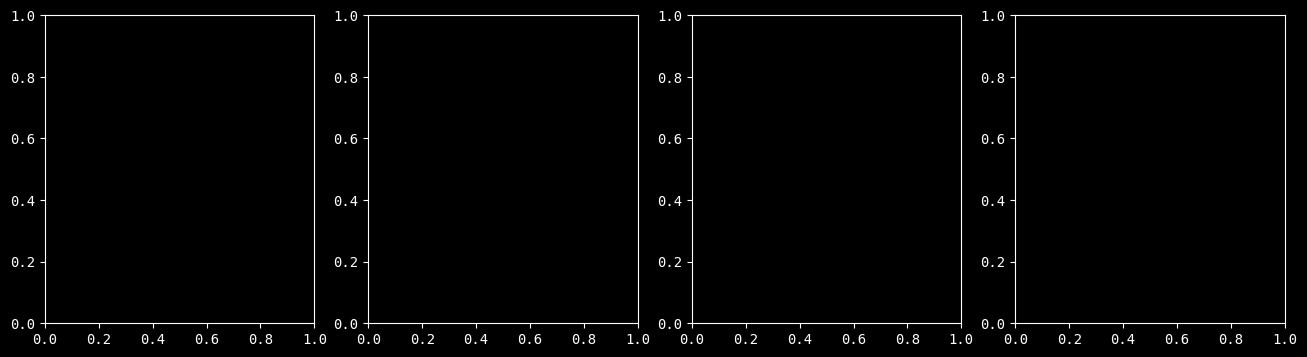

In [18]:
# Final sprint time distribution per distance
fig, axes = plt.subplots(1, len(DISTANCES), figsize=(4 * len(DISTANCES), 4), sharey=False)

for ax, dist in zip(axes, DISTANCES):
    subset = df_valid[df_valid['distance'] == dist]['final_dur']
    if len(subset) == 0:
        ax.set_title(f'{dist}m (no data)')
        continue
    ax.hist(subset, bins=20, color='#0A84FF', alpha=0.8, edgecolor='#0d1117')
    ax.axvline(subset.median(), color='#FF9F0A', linestyle='--', label=f'median {subset.median():.2f}s')
    ax.set_title(f'{dist}m (n={len(subset)})')
    ax.set_xlabel('Sprint time (s)')
    ax.legend(fontsize=8)

axes[0].set_ylabel('Count')
fig.suptitle('Detected sprint end times', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Forward vs Backward scatter — are they correlated?
fig, axes = plt.subplots(1, len(DISTANCES), figsize=(4 * len(DISTANCES), 4))

for ax, dist in zip(axes, DISTANCES):
    subset = df_valid[df_valid['distance'] == dist]
    if len(subset) == 0:
        ax.set_title(f'{dist}m (no data)')
        continue
    ax.scatter(subset['fwd_dur'], subset['bwd_dur'], alpha=0.6, s=20, color='#BF5AF2')
    lims = [subset[['fwd_dur', 'bwd_dur']].min().min(), subset[['fwd_dur', 'bwd_dur']].max().max()]
    ax.plot(lims, lims, '--', color='#39FF14', alpha=0.5, label='perfect agreement')
    ax.set_title(f'{dist}m')
    ax.set_xlabel('Forward (s)')
    ax.set_ylabel('Backward (s)')
    ax.legend(fontsize=8)

fig.suptitle('Forward vs Backward detection', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Reaction time

In [ ]:
df_rt = df_valid.dropna(subset=['reaction_time']).copy()
print(f"Sprints with reaction time data: {len(df_rt)} / {len(df_valid)}")

if len(df_rt) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    axes[0].hist(df_rt['reaction_time'], bins=30, color='#FFD60A', alpha=0.8, edgecolor='#0d1117')
    axes[0].axvline(0.1, color='#FF3B30', linestyle=':', alpha=0.7, label='0.1s (false start threshold)')
    axes[0].axvline(df_rt['reaction_time'].median(), color='#39FF14', linestyle='--', label=f'median {df_rt["reaction_time"].median():.3f}s')
    axes[0].set_xlabel('Reaction time (s)')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Reaction time distribution (all distances)')
    axes[0].legend()

    # Box plot per distance
    rt_by_dist = [df_rt[df_rt['distance'] == d]['reaction_time'].values for d in DISTANCES]
    bp = axes[1].boxplot(
        [x for x in rt_by_dist if len(x) > 0],
        labels=[f'{d}m' for d, x in zip(DISTANCES, rt_by_dist) if len(x) > 0],
        patch_artist=True,
    )
    for patch in bp['boxes']:
        patch.set_facecolor('#FFD60A')
        patch.set_alpha(0.5)
    axes[1].axhline(0.1, color='#FF3B30', linestyle=':', alpha=0.7)
    axes[1].set_ylabel('Reaction time (s)')
    axes[1].set_title('Reaction time by distance')

    plt.tight_layout()
    plt.show()

    # Flag suspicious values
    suspicious = df_rt[(df_rt['reaction_time'] < 0.08) | (df_rt['reaction_time'] > 1.0)]
    if len(suspicious) > 0:
        print(f"\n⚠ {len(suspicious)} suspicious reaction times (<0.08s or >1.0s):")
        print(suspicious[['user_id', 'date', 'distance', 'reaction_time', 'is_false_start']].to_string(index=False))
    else:
        print("\nAll reaction times within plausible range (0.08–1.0s)")

## 5. Per-user breakdown

In [ ]:
user_stats = df_valid.groupby('user_id').agg(
    sprints=('final_dur', 'count'),
    agree_pct=('decision', lambda x: (x == 'agree').mean() * 100),
    median_gap=('gap', 'median'),
    max_gap=('gap', 'max'),
).sort_values('agree_pct')

print(f"Users with lowest agree %  (potential algorithm issues):\n")
print(user_stats.head(10).round(1).to_string())

In [ ]:
# Agree rate vs number of sprints — do power users have better detection?
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(user_stats['sprints'], user_stats['agree_pct'], alpha=0.7, s=40, color='#39FF14')
ax.set_xlabel('Number of sprints')
ax.set_ylabel('Agree %')
ax.set_title('Detection agreement rate per user')
ax.axhline(50, color='#FF3B30', linestyle=':', alpha=0.5, label='50% threshold')
ax.legend()
plt.tight_layout()
plt.show()

## 6. Outliers & failures

In [ ]:
# Sprints where gap > 3s — likely algorithm struggles
outliers = df_valid[df_valid['gap'] > 3.0].sort_values('gap', ascending=False)
print(f"Sprints with gap > 3s: {len(outliers)} / {len(df_valid)} ({100*len(outliers)/max(len(df_valid),1):.1f}%)\n")

if len(outliers) > 0:
    print(outliers[['user_id', 'date', 'distance', 'fwd_dur', 'bwd_dur', 'gap', 'decision', 'final_dur']].head(20).to_string(index=False))

In [ ]:
# Summary table
summary = df_valid.groupby('distance').agg(
    n=('final_dur', 'count'),
    agree_pct=('decision', lambda x: (x == 'agree').mean() * 100),
    median_time=('final_dur', 'median'),
    median_gap=('gap', 'median'),
    mean_gap=('gap', 'mean'),
    pct_gap_over_2s=('gap', lambda x: (x > 2.0).mean() * 100),
    unique_users=('user_id', 'nunique'),
).round(2)

print("=" * 70)
print("VALIDATION SUMMARY")
print("=" * 70)
print(summary.to_string())